Kaggle competition: https://www.kaggle.com/c/digit-recognizer/

We need to import Torch's libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns

import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

## Data preparation

A custom dataset which uses the CSV from Kaggle, avoid downloading the dataset from internet

### Hyperparams

In [2]:
# hyperparams
num_epochs = 100
batch_size = 128
learning_rate = 2e-2
momentum = 0.6

In [3]:
class MyMNISTDataset(Dataset):
    
    def __init__(
        self,
        file_path,
        test_data=False,
        use_gpu=torch.cuda.is_available()
    ):

        # read the data
        df = pd.read_csv(file_path)
        # for test data we don't have any target
        # MNIST images are 28 by 28, grey colors
        if test_data:
            self.X = torch.tensor(df.apply(lambda x: ((x / 255) - 0.5) * 2).values, dtype=torch.float32)
            self.y = None
        else:
            self.X = torch.tensor(df.iloc[:, 1:].apply(lambda x: ((x / 255) - 0.5) * 2).values, dtype=torch.float32)
            self.y = torch.tensor(pd.get_dummies(df['label']).values, dtype=torch.float32)

        if use_gpu:
            self.X = self.X.to('cuda')
            if self.y is not None:
                self.y = self.y.to('cuda')
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is not None:
            return self.X[idx], self.y[idx]
        else:
            return self.X[idx]

In [4]:
train_dataset = MyMNISTDataset('data/train.csv', test_data=False, use_gpu=True)
test_dataset = MyMNISTDataset('data/test.csv', test_data=True, use_gpu=True)

In [5]:
# split train between validation and training set
train_size = int(0.8 * len(train_dataset))
validation_size = len(train_dataset) - train_size

# random_split creates subsets
train_subset, validation_subset = torch.utils.data.random_split(train_dataset, [train_size, validation_size], generator=torch.Generator().manual_seed(0))

# create data loaders
train_dataloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_subset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### WandB init

In [6]:
import wandb

wandb.init(project='MNIST', dir='C:/temp/wandb', config={
    'num-epochs': num_epochs,
    'learning-rate': learning_rate,
    'batch-size': batch_size,
    'momentum': momentum
})

wandb: Currently logged in as: fischly. Use `wandb login --relogin` to force relogin


## MLP

### Define model architecture
You need to reach at least 70% accuracy on the test set

In [10]:
def init_linear_layer(m, method):
    torch.nn.init.xavier_normal_(m.weight, nn.init.calculate_gain(method))
    torch.nn.init.constant_(m.bias, 0)
    return m


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=24, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        self.ln1 = init_linear_layer(nn.Linear(600, 400), 'relu')
        self.ln2 = init_linear_layer(nn.Linear(400, 10), 'linear')
        
        self.softmax = nn.Softmax(dim=1)
        
        self.dropout1 = nn.Dropout2d(0.2)
        self.dropout2 = nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool2(x)
        
        x = x.reshape((x.shape[0], -1))
        
        x = self.ln1(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.ln2(x)
        
        return self.softmax(x)

### Init the model and put it on GPU

In [12]:
net = Net()
loss = nn.BCELoss() #  nn.NLLLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

net.to('cuda')

net.train()

wandb.watch(net, log='all', criterion=loss, log_freq=8,  log_graph=(True))

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


### Training loop
Log the accuracy and the loss to wandb

epoch: 0, accuracy: 0.7235714285714285, validation_loss: 9.397342085838318
epoch: 1, accuracy: 0.8597619047619047, validation_loss: 5.108422372490168
epoch: 2, accuracy: 0.8971428571428571, validation_loss: 3.7653157897293568
epoch: 3, accuracy: 0.9160714285714285, validation_loss: 3.1921010743826628
epoch: 4, accuracy: 0.9242857142857143, validation_loss: 2.8304641284048557
epoch: 5, accuracy: 0.9319047619047619, validation_loss: 2.4979544207453728
epoch: 6, accuracy: 0.9415476190476191, validation_loss: 2.266569184139371
epoch: 7, accuracy: 0.9473809523809524, validation_loss: 2.05205200612545
epoch: 8, accuracy: 0.949047619047619, validation_loss: 1.9929645154625177
epoch: 9, accuracy: 0.9483333333333334, validation_loss: 1.9018743643537164
epoch: 10, accuracy: 0.9558333333333333, validation_loss: 1.7044041007757187
epoch: 11, accuracy: 0.958452380952381, validation_loss: 1.6836060853675008
epoch: 12, accuracy: 0.9588095238095238, validation_loss: 1.6377075798809528
epoch: 13, accur

<AxesSubplot:xlabel='epoch', ylabel='accuracy'>

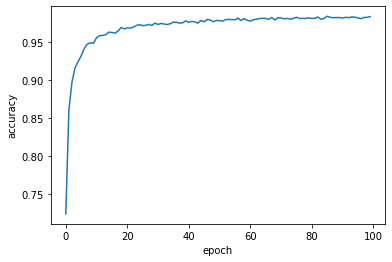

In [13]:
epoch_losses = []

for epoch in range(num_epochs):
    training_loss = 0
    
    # ======== TRAINING ========
    for (X, y) in train_dataloader:
        y_hat = net(X.reshape((-1, 1, 28, 28)))
        l = loss(y_hat, y)  # torch.argmax(y, dim=1))
        
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        
        training_loss += l.item()
        
    # ======== VALIDATION ========
    validation_loss = 0
    validation_counter = 0
    correct_counter = 0
    with torch.no_grad():
        for (X, y) in validation_dataloader:
            y_hat = net(X.reshape((-1, 1, 28, 28)))
            l = loss(y_hat, y) #  torch.argmax(y, dim=1))
            
            validation_loss += l.item()
            
            num_correct = (torch.argmax(y_hat, dim=1) == torch.argmax(y, dim=1)).sum()
            
            validation_counter += len(y)
            correct_counter += num_correct.item()
    
    print(f'epoch: {epoch}, accuracy: {correct_counter/validation_counter}, validation_loss: {validation_loss}')
    epoch_losses.append({'epoch': epoch, 'trainloss': training_loss, 'valloss': validation_loss, 'accuracy': correct_counter/validation_counter})
    wandb.log({'epoch': epoch, 'training_loss': training_loss, 'validation_loss': validation_loss, 'accuracy': correct_counter/validation_counter})


torch.save(net.state_dict(), f'models/model-1.pt')

sns.lineplot(data=pd.DataFrame(epoch_losses), x='epoch', y='accuracy')

### Make prediction
And submit to Kaggle for grading

In [14]:
with torch.no_grad():
    net.eval()
    
    test_pred = torch.LongTensor()
    for i, data in enumerate(test_dataloader):
        y_hat = net(data.reshape((-1, 1, 28, 28)))
        predicted = torch.argmax(y_hat, dim=1)
        
        predicted = predicted.cpu()
        test_pred = torch.cat((test_pred, predicted), dim=0)
    out_df = pd.DataFrame(np.c_[np.arange(1, len(test_dataset)+1)[:,None], test_pred.numpy()], columns=['ImageId', 'Label'])
    out_df.to_csv('submission.csv', index=False)

### 10 most misclafficied image

In [15]:
import matplotlib.pyplot as plt

top_ten_misclassified = 0
unshuffle_train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=False)

with torch.no_grad():
    net.eval()
    missclasified = torch.DoubleTensor()
    for batch_idx, (data, target) in enumerate(unshuffle_train_loader):
        y_hat = net(data.reshape((-1, 1, 28, 28)))
        prob, predicted = torch.max(y_hat, 1)
        
        # print(prob)
        # print(torch.min(prob))
        # print(torch.argmin(prob))
        # print('predicted', predicted)
        
        
        predicted = predicted.cpu()
        target = torch.argmax(target, dim=1).cpu()
        prob = prob.cpu().double()
        
        # print('target', target)
        
        
        
        missclassified_prob = torch.where(predicted == target, 0., prob)
        missclasified = torch.cat((missclasified, missclassified_prob), dim=0)

    # print('missclasified', missclasified)
    most_misclassified = torch.argsort(missclasified, descending=True)
    # print('most_misclassified', most_misclassified)
    top_ten_misclassified = most_misclassified[:10]

top_ten_misclassified

tensor([30267, 31851, 30190,  8291, 33102, 27799, 33569, 30742, 10387,  2319])

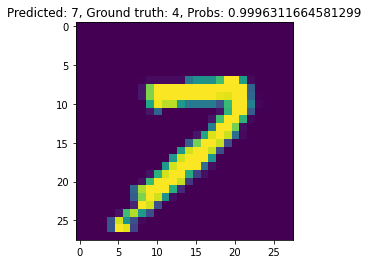

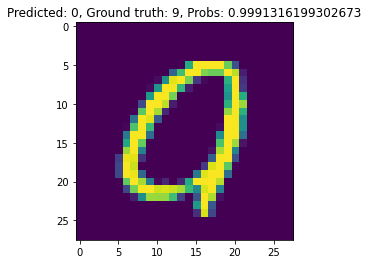

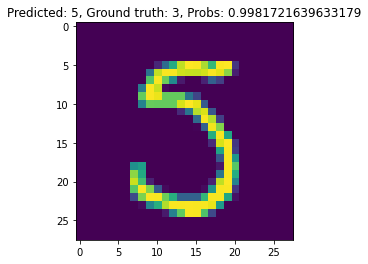

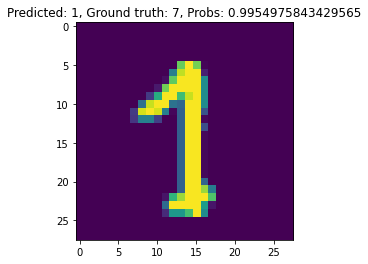

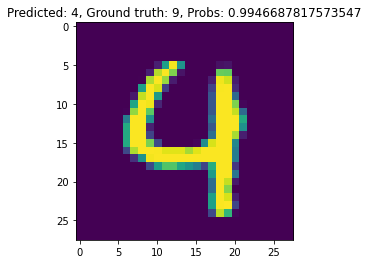

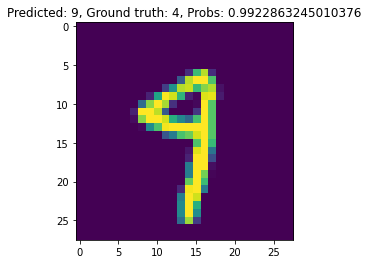

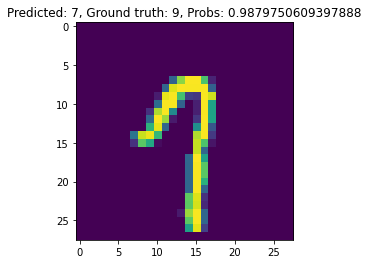

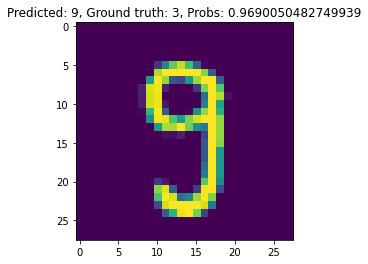

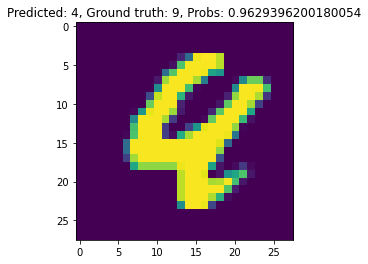

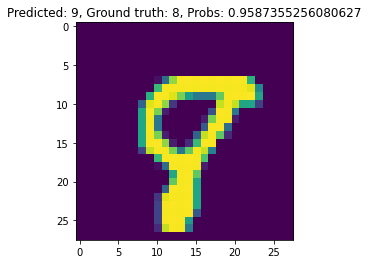

In [16]:
for misclassified in top_ten_misclassified:
    plt.imshow(train_subset[misclassified][0].cpu().reshape(28,28))
    with torch.no_grad():
        data, target = train_subset[misclassified]
        data = data.reshape(1, 28*28)
        output = net(data.reshape((-1, 1, 28, 28)))
        prob, predicted = torch.max(output.data, 1)
        plt.title(f'Predicted: {predicted.item()}, Ground truth: {torch.argmax(target)}, Probs: {prob.item()}')
    plt.show()

In [ ]:
2